Import the Needed Libraries

In [ ]:
import pandas as pd
from sklearn.metrics import silhouette_score
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

Data Preparation

In [ ]:
df = pd.read_excel('data/Online Retail.xlsx') # Load the Dataset

# Drop the Rows where we have a null value
clean_df = df.dropna() 

In [ ]:
# Filter out cancellations (Quantity < 0) and bad Price data
# We use .copy() to avoid SettingWithCopy warnings later
clean_df = clean_df.query("Quantity > 0 and UnitPrice > 0").copy()

In [13]:
# We are making sure that the datatype is not incorrect
clean_df['CustomerID'] = clean_df['CustomerID'].astype(int) # Make sure that this columns is Integer
clean_df['InvoiceDate'] = pd.to_datetime(clean_df['InvoiceDate']) # Make sure that this column has date format

In [ ]:
# Create a column names TotalSum
clean_df['TotalSum'] = clean_df['Quantity'] * clean_df['UnitPrice']

0    15.30
1    20.34
2    22.00
3    20.34
4    20.34
5    15.30
6    25.50
7    11.10
8    11.10
9    54.08
Name: TotalSum, dtype: float64


Prepare the Data for the RFM Analysis

In [27]:
# Calculate the Snapshot Date
snapshot_date = clean_df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Aggregate data at the customer level
rfm = clean_df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days, # Recency
    'InvoiceNo': 'nunique',                                 # Frequency
    'TotalSum': 'sum'                                       # Monetary
})

# Rename the columns for clarity
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalSum': 'Monetary'
}, inplace=True)

print(rfm.head())

            Recency  Frequency  Monetary
CustomerID                              
12346           326          1  77183.60
12347             2          7   4310.00
12348            75          4   1797.24
12349            19          1   1757.55
12350           310          1    334.40


Machine Learning

In [ ]:
# Unskew the data with Log Transformation
# We add 1 if there are any zeros, as log(0) is undefined
rfm_log = np.log(rfm)

# Initialize a scaler
scaler = StandardScaler()

# Fit and Transform the data
rfm_normalized = scaler.fit_transform(rfm_log)

# Convert back to a DataFrame for easier handling
rfm_normalized = pd.DataFrame(
    data=rfm_normalized, 
    index=rfm.index, 
    columns=rfm.columns
)

print("Normalized RFM Data:")
print(rfm_normalized.head())

Normalized RFM Data:
             Recency  Frequency  Monetary
CustomerID                               
12346       1.409894  -1.048610  3.698719
12347      -2.146498   1.111836  1.410201
12348       0.383971   0.490522  0.716419
12349      -0.574674  -1.048610  0.698706
12350       1.374758  -1.048610 -0.617446


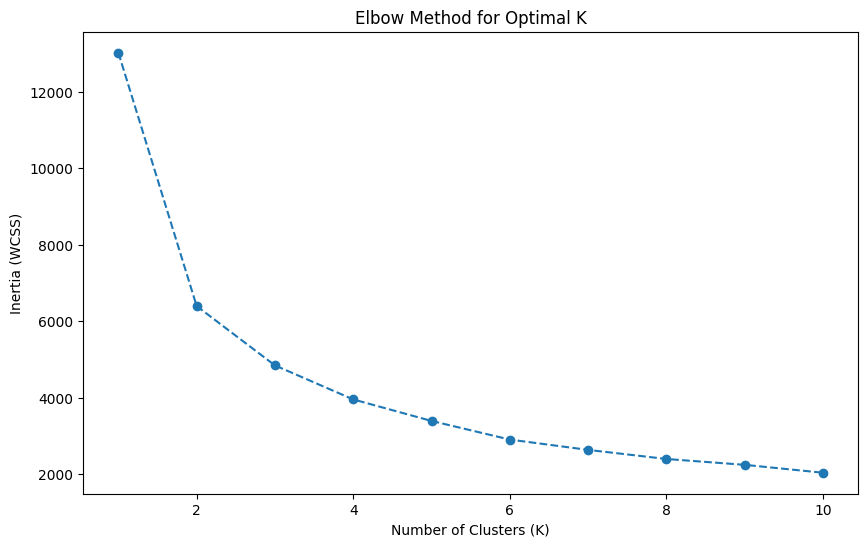

In [ ]:
# Calculate Inertia for a range of K values
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_normalized)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (WCSS)')
plt.show()

Training the model

In [24]:
# Initialize the model with chosen K
kmeans = KMeans(n_clusters=2, random_state=42)

# Fit and predict
cluster_labels = kmeans.fit_predict(rfm_normalized)

# Add the cluster labels back to our original RFM data
rfm['Cluster'] = cluster_labels

print(rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).round(2))


         Recency  Frequency  Monetary
Cluster                              
0         136.28       1.62    473.29
1          27.73       8.20   4396.79
